0. **[Stuff](#0.-Stuff)**<br>
    0.1 [About the notebook](#0.1-About-the-notebook)<br>
    0.2 [Imports](#0.2-Imports)<br>
    0.3 [Definitions](#0.3-Definitions)<br>
    0.4 [Local functions](#0.4-Local-functions)<br>
1. **[Derive quantities](#1.-Derive-quantities)**<br>
2. **[Plots based on s1](#2.-Plots-based-on-s1)**<br>
    2.1 [cs1 in pe](#2.1-cs1-in-pe)<br>
    2.2 [cs1_in_keV](#2.2-cs1-in-keV)<br>
3. **[Plots based on s2](#3.-Plots-based-on-s2)**<br>
    3.1 [cs2 in pe](#3.1-cs2_in_pe)<br>
    3.2 [cs2 in keV](#3.1-cs2_in_keV)<br>
4. **[Plots based on combined energy scale](#4.-Plots-based-on-combined-energy-scale)**<br>
    4.1 [define combined energy scale](#4.1-define-combined-energy-scale)<br>
    4.2 [combined in keV](#4.2-combined-in-keV)<br>

# 0. Stuff

## 0.1 About the notebook

In [1]:
### This notebook is meant investigate the energy resolution of the detector based on the detector
### specific gains g1 and g2 extracted by another notebook. Since these parameters strongly depend on
### the amplification field. Anode was set on 1kV, which results in an amp_field of 3kV/0.5cm 

### Hard coded g1 in pe/gamma and g2 in pe/electron only valid for runs with amp_field = 3kV/0.5cm!

## 0.2 Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2 

import sys
sys.path.append("/data/workspace/Patrick/Analysis")
import functions as fc

Using TensorFlow backend.


## 0.3 Definitions

In [3]:
ctx = straxbra.XebraContext()
run = '00188'
peaks_data = ctx.get_array(run, 'peaks')
position_data = ctx.get_array(run, 'peak_positions')
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]

## 0.4 Local functions

In [4]:
def Process(waveform,i,drifttime_list, s2_list, aii, bii, timestamp,cs1_list): 
    SelectionCutFlag = fc.CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  fc.S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if fc.S2_found(integral = integral[i+j], width = width[i+j]):
                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = fc.drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and fc.S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] < 50000:
                        cs1.append(integral[i]/(-0.0069 *z_position + 0.76))
                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        return
                    else:
                        return
                return
            else:
                return
    else:
        return

    
    
def Process_2(waveform,i,drifttime_list, s2_list, aii, bii, timestamp,cs1_list,electron_lifetime): 
    SelectionCutFlag = fc.CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  fc.S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if fc.S2_found(integral = integral[i+j], width = width[i+j]):
                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = fc.drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and fc.S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] < 50000:
                        time       = timestamp[i+j] - timestamp[i]
                        S2 = integral[i+j]
                        s2_corrected= S2/(np.exp(-time/(electron_lifetime*1e3)))
                        cs2.append(s2_corrected)
                        return
                    else:
                        return
                return
            else:
                return
    else:
        return

def compute_lifetime(s2,drifttime):

    
    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(3,4.5,50) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            u =fc.poisson_interval(j)[1]
            error_per_slice.append(u)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(1000,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,30):   
        popt, pcov = curve_fit(fc.log_gaus, ycenter, counts[i], p0, sigma = poisson_list[i], absolute_sigma = True, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))


        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)

#         expectation = np.exp(popt[1]-popt[2]**2)
#         expectation_list.append(expectation)
#         diff_mu = expectation
#         diff_sigma = expectation * 2 * popt[2]
#         error_mu = perr[1]
#         error_sigma = perr[2] 
#         error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
#         error_list.append(error)


 
    p1=  [10000,0.1]
    x = np.linspace(5,30,25)
    popt, pcov = curve_fit(fc.expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
#    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    
    return (lifetime, lifetime_error)

# 1. Derive quantities

In [5]:
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23
s2 = []
drifttime = []
cs1 = []
cs2 = []
g1 = 0.115                             ###### in pe/gamma              extracted in "s1_s2_anticorrelation"
g2 = 7.915                              ###### in pe/electron           
W = 13.7                              ###### Energy required to ionise xenon (given in multiple papers)

In [6]:
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process(waveform,i,drifttime_list = drifttime, s2_list = s2, aii=a, bii=b, timestamp=timestamp,cs1_list = cs1)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00188 done!


In [7]:
electron_lifetime, lifetime_error = compute_lifetime(s2,drifttime)    

In [8]:
print(electron_lifetime)

152.84683270176447


In [9]:
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process_2(waveform,i,drifttime_list = drifttime, s2_list = s2, aii=a, bii=b, timestamp=timestamp,cs1_list = cs1, electron_lifetime=electron_lifetime)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00188 done!


# 2. Plots based on s1

## 2.1 cs1 in pe

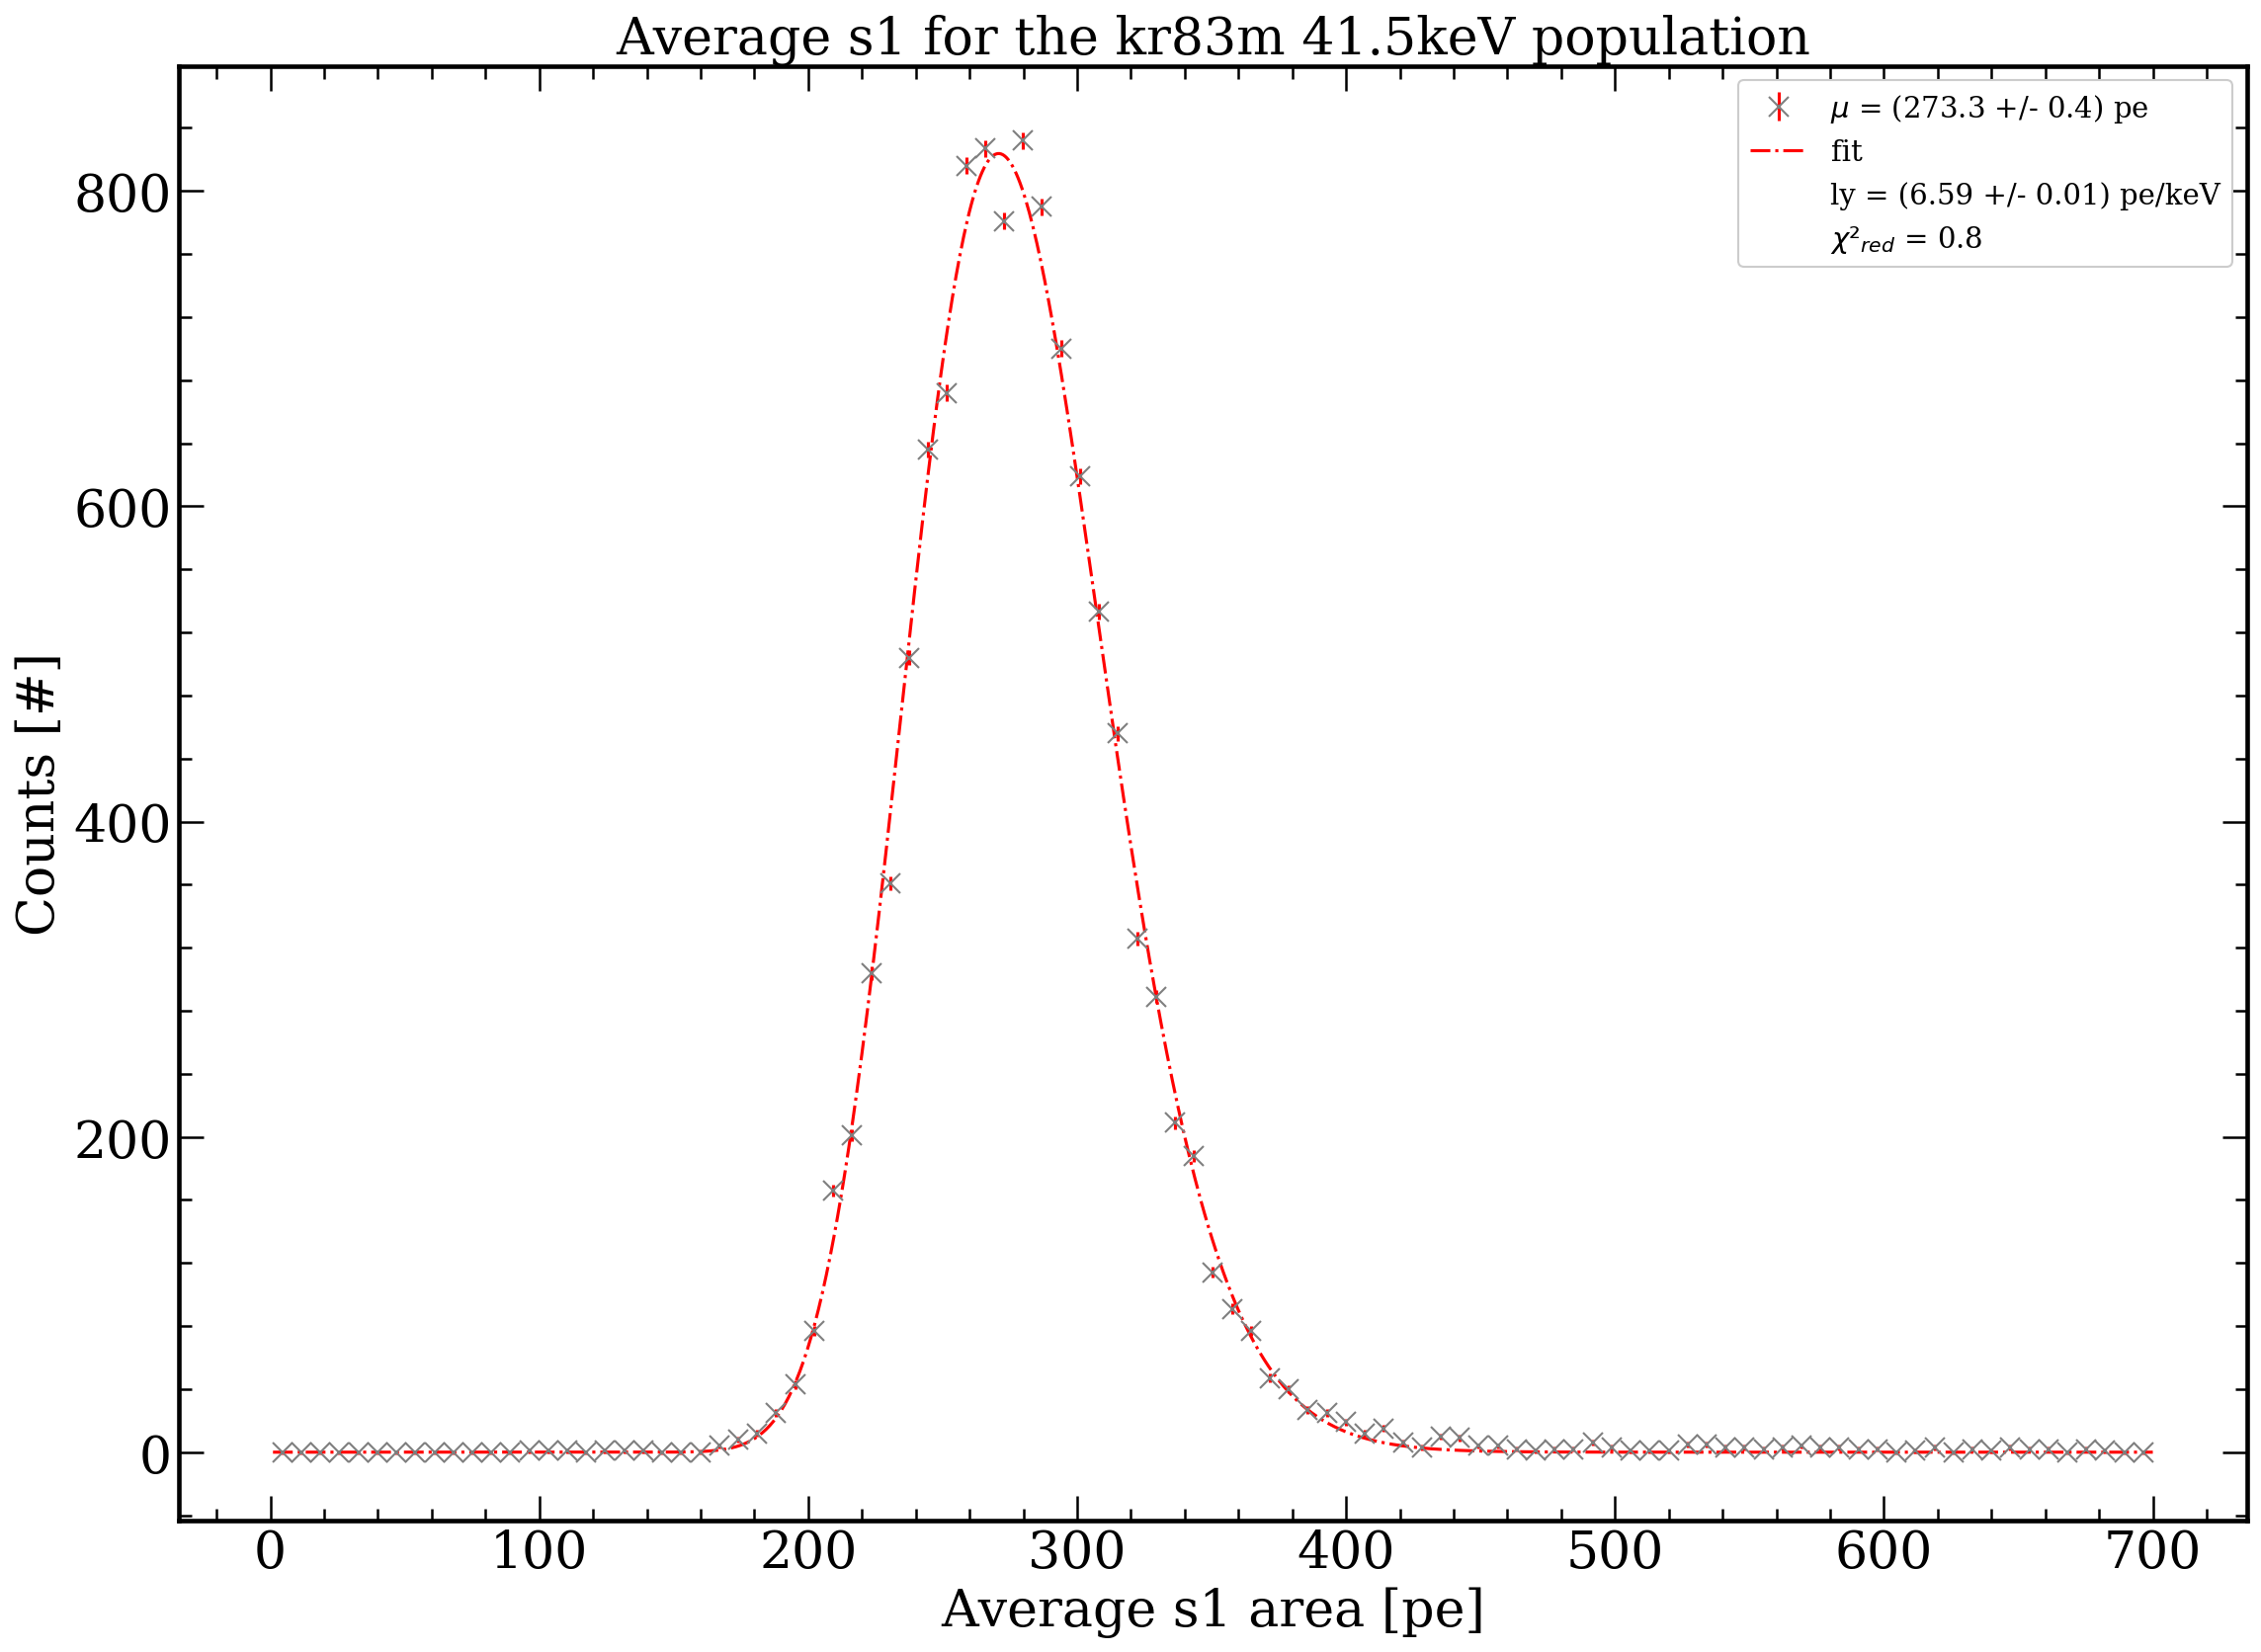

In [27]:
fig, axes = ps.styles()

p0_log = [1,1,1]
p0 = [500,300,60]



    
n_s1, binEdges_s1 = np.histogram(cs1, bins=np.linspace(1,700,100))  #anode at 2500V

poisson_list_s1 = []

for i in n_s1:
    q= fc.poisson_interval(i)[1]
    poisson_list_s1.append(q)


bincenters_s1 = 0.5 * (binEdges_s1[1:] + binEdges_s1[:-1])
x_range_s1 = np.linspace(1,700,1000)

popt_s1, pcov_s1 = curve_fit(fc.log_gaus, bincenters_s1, n_s1, p0_log,  sigma = poisson_list_s1, absolute_sigma = True, maxfev = 10000)
perr_s1 = np.sqrt(np.diag(pcov_s1))



# expectation_s1 = np.exp(popt_s1[1]-popt_s1[2]**2)
# diff_mu_s1 = expectation_s1
# diff_sigma_s1 = expectation_s1 * 2 * popt_s1[2]
# error_mu_s1 = perr_s1[1]
# error_sigma_s1 = perr_s1[2] 
# error_s1 = np.sqrt(diff_mu_s1**2 * error_mu_s1**2 + diff_sigma_s1**2 * error_sigma_s1**2)



expectation_s1 = np.exp(popt_s1[1]+((popt_s1[2]**2)/2))
diff_mu_s1 = expectation_s1
diff_sigma_s1 = expectation_s1*popt_s1[2]
error_mu_s1 = perr_s1[1]
error_sigma_s1 = perr_s1[2]   
error_s1 = np.sqrt(diff_mu_s1**2 * error_mu_s1**2 + diff_sigma_s1**2 * error_sigma_s1**2)

s1_mu = f"{expectation_s1:.1f}"


s1_ly = f"{(np.array(expectation_s1)/41.5):.2f}"
s1_ly_error = f"{(np.array(error_s1)/41.5):.2f}"
#print('average ly of run',run[2:],': (',s1_ly,'+/-',s1_ly_error,')','keV/pe')
s1_error = f"{error_s1:.1f}"




xdata_s1=bincenters_s1[1:-1]
ydata_s1=n_s1[1:-1]
chi_squared_s1 =  (np.sum((n_s1 - fc.log_gaus(bincenters_s1, *popt_s1))**2 / np.array(poisson_list_s1)**2))
Reduced_chi_squared_s1 ="%.1f" %( chi_squared_s1 / len(xdata_s1))


axes.errorbar(bincenters_s1, n_s1, yerr=np.sqrt(poisson_list_s1),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red', label='$\mu$ = ('+s1_mu+' +/- '+s1_error+') pe')


axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_s1)
axes.plot([], [], ' ', label='ly = ('        +s1_ly+' +/- '+s1_ly_error+') pe/keV')
axes.plot(x_range_s1,fc.log_gaus(x_range_s1,*popt_s1), color = 'red', linestyle = '-.', label = 'fit')

handles,labels = axes.get_legend_handles_labels()
handles = [handles[3],handles[2],handles[1],handles[0]]
labels = [labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)



axes.set_title('Average s1 for the kr83m 41.5keV population')
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s1 area [pe]')
plt.show()


## 2.2 cs1 in keV

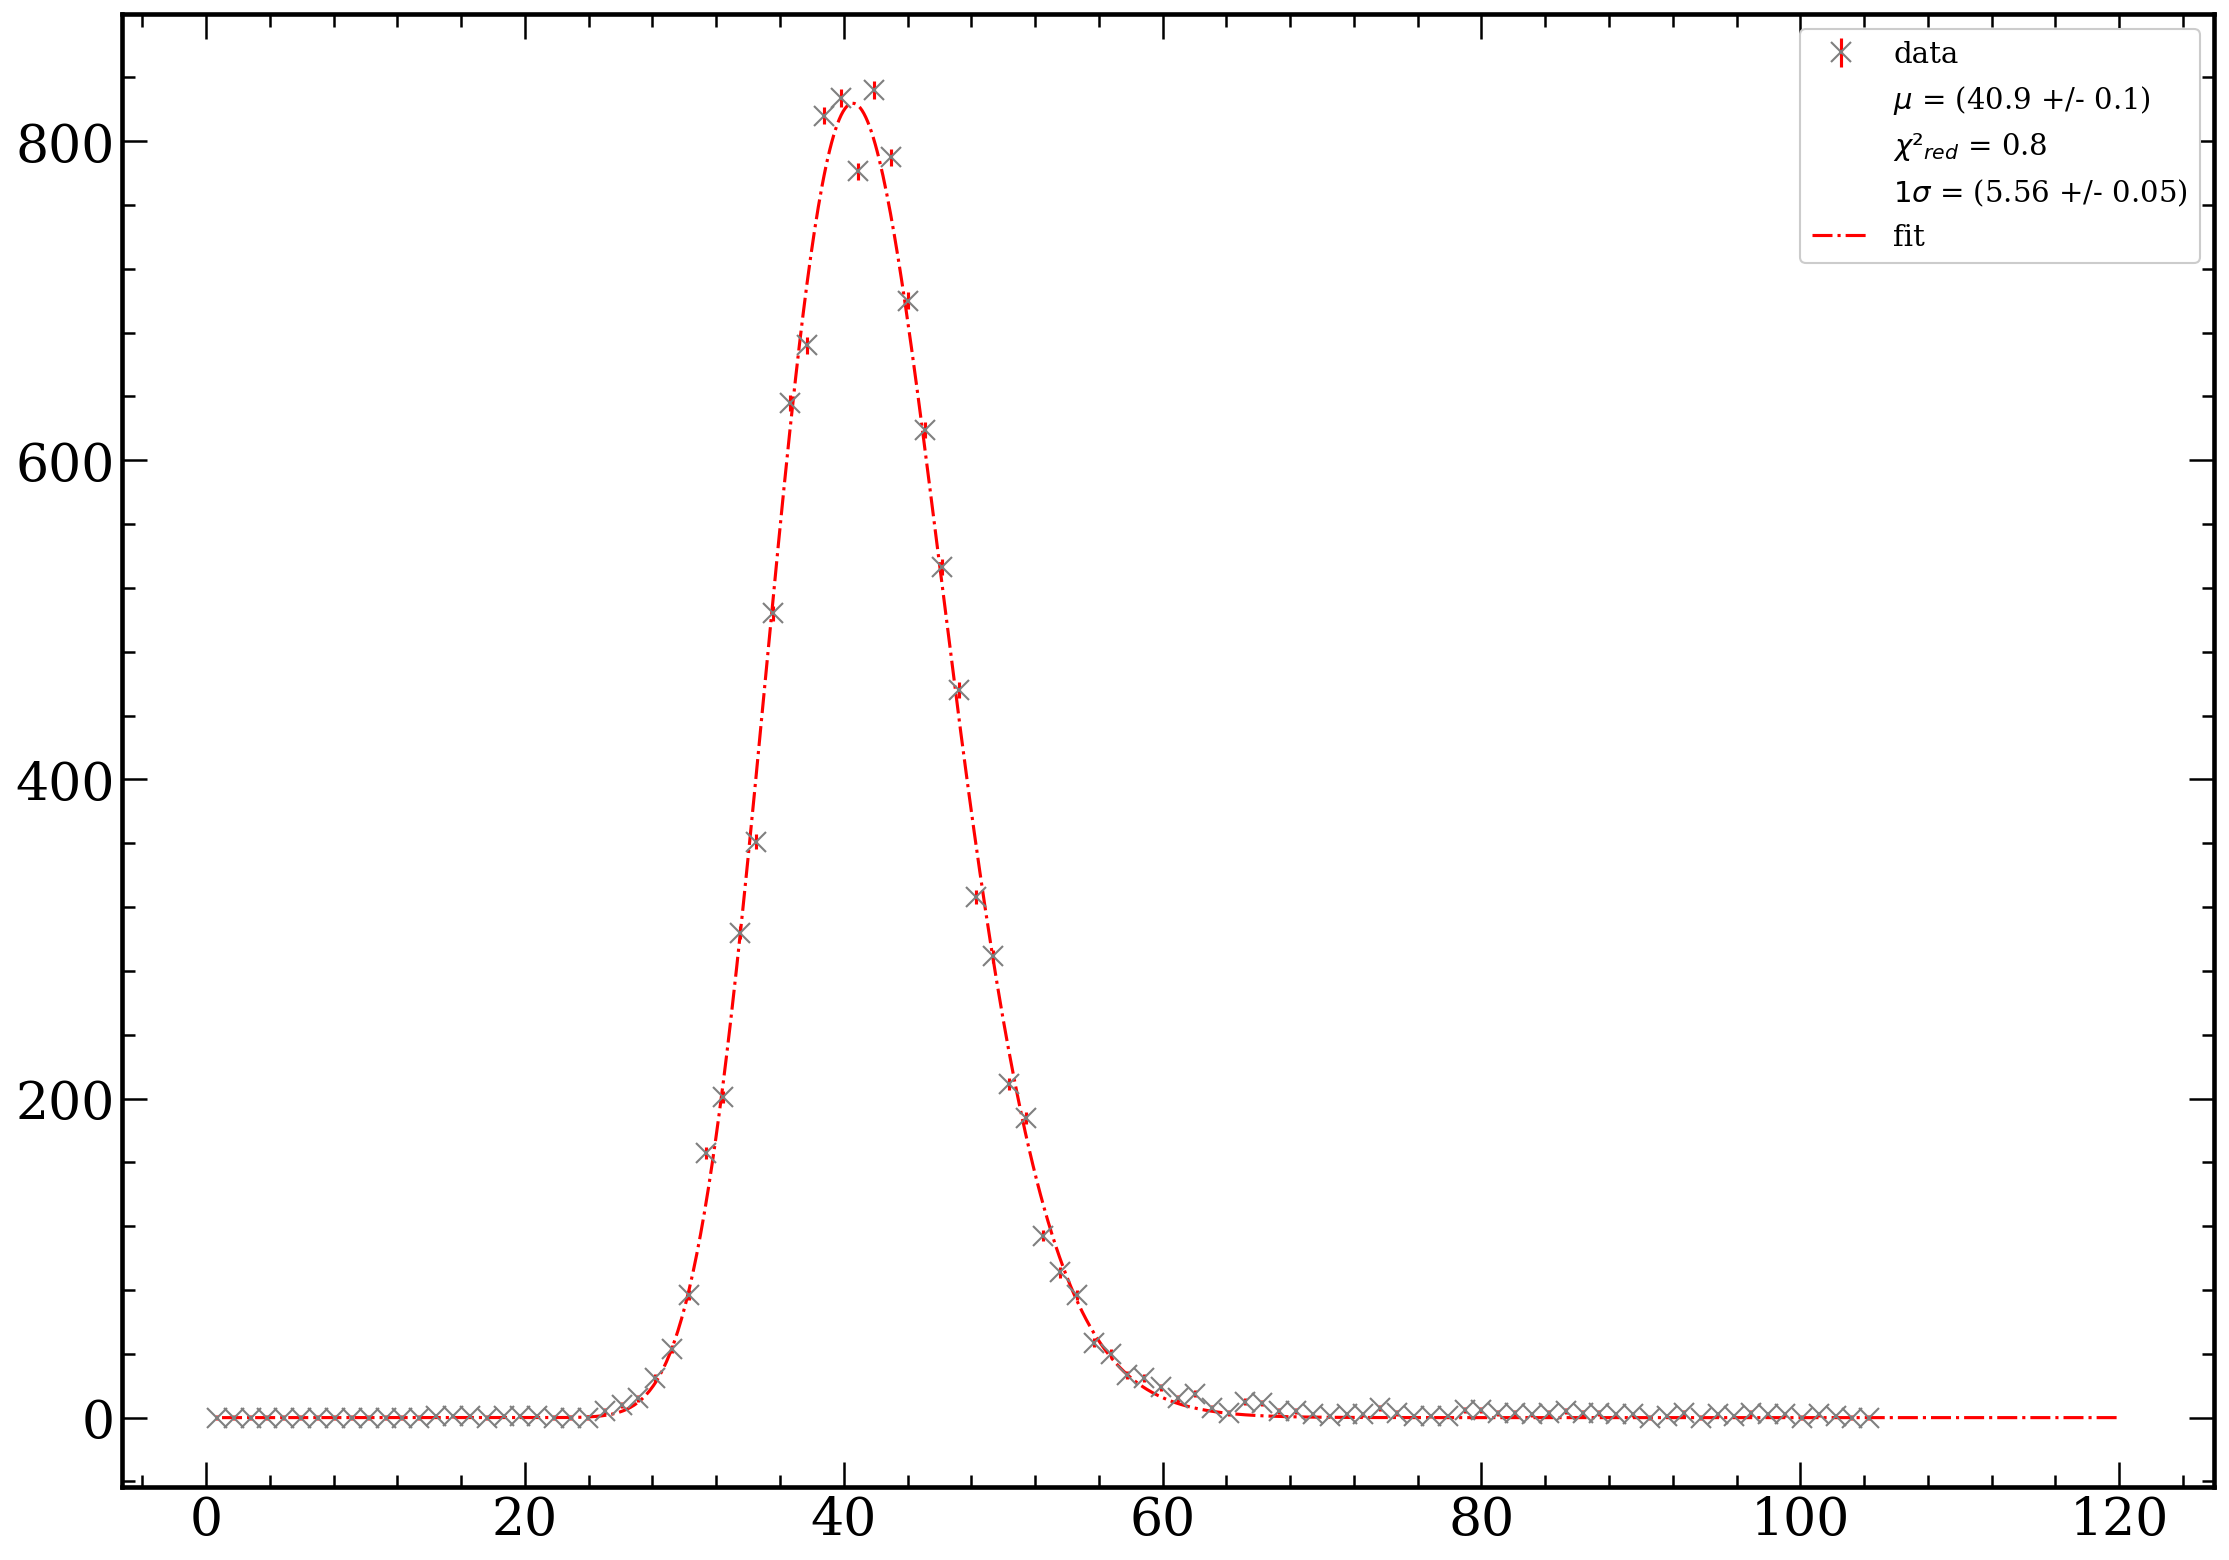

In [26]:
fig, axes = ps.styles()

bincenters_scaled_s1 =np.array(bincenters_s1)/(np.array(expectation_s1)/41.5)
x_range_scaled_s1 = np.linspace(1,120,1000)

poisson_list_scaled_s1 = []

for i in n_s1:
    q= fc.poisson_interval(i)[1]
    poisson_list_scaled_s1.append(q)

popt_scaled_s1, pcov_scaled_s1 = curve_fit(fc.log_gaus, bincenters_scaled_s1, n_s1, p0_log,  sigma = poisson_list_scaled_s1, absolute_sigma = True, maxfev = 10000)
perr_scaled_s1 = np.sqrt(np.diag(pcov_scaled_s1))




# expectation_scaled_s1 = np.exp(popt_scaled_s1[1]-popt_scaled_s1[2]**2)
# diff_mu_scaled_s1 = expectation_scaled_s1
# diff_sigma_scaled_s1 = expectation_scaled_s1 * 2 * popt_scaled_s1[2]
# error_mu_scaled_s1 = perr_scaled_s1[1]
# error_sigma_scaled_s1 = perr_scaled_s1[2] 
# error_scaled_s1 = np.sqrt(diff_mu_scaled_s1**2 * error_mu_scaled_s1**2 + diff_sigma_scaled_s1**2 * error_sigma_scaled_s1**2)






expectation_scaled_s1 = np.exp(popt_scaled_s1[1]+((popt_scaled_s1[2]**2)/2))
diff_mu_scaled_s1 = expectation_scaled_s1
diff_sigma_scaled_s1 = expectation_scaled_s1*popt_scaled_s1[2]
error_mu_scaled_s1 = perr_scaled_s1[1]
error_sigma_scaled_s1 = perr_scaled_s1[2]   
error_scaled_s1 = np.sqrt(diff_mu_scaled_s1**2 * error_mu_scaled_s1**2 + diff_sigma_scaled_s1**2 * error_sigma_scaled_s1**2)

s1_scaled_mu = f"{expectation_scaled_s1:.1f}"


s1_scaled_ly = f"{(np.array(expectation_scaled_s1)/41.5):.2f}"
s1_scaled_ly_error = f"{(np.array(error_scaled_s1)/41.5):.2f}"
#print('average ly of run',run[2:],': (',s1_ly,'+/-',s1_ly_error,')','keV/pe')
s1_scaled_error = f"{error_scaled_s1:.1f}"




xdata_scaled_s1=bincenters_scaled_s1[1:-1]
ydata_scaled_s1=n_s1[1:-1]
chi_squared_scaled_s1 =  (np.sum((n_s1 - fc.log_gaus(bincenters_scaled_s1, *popt_scaled_s1))**2 / np.array(poisson_list_scaled_s1)**2))
Reduced_chi_squared_scaled_s1 ="%.1f" %( chi_squared_scaled_s1 / len(xdata_scaled_s1))


s1_scaled_sigma = np.exp(popt_scaled_s1[1]+((popt_scaled_s1[2]**2)/2))    * np.sqrt(np.exp(popt_scaled_s1[2]**2)-1)
diff_mu_scaled_s1 = s1_scaled_sigma
diff_sigma_scaled_s1 = expectation_scaled_s1 * popt_scaled_s1[2] * (np.sqrt(np.exp(popt_scaled_s1[2]**2)-1)+1/(np.sqrt(np.exp(popt_scaled_s1[2]**2)-1))*np.exp(popt_scaled_s1[2]**2)) 
s1_scaled_sigma_error = np.sqrt(diff_mu_scaled_s1**2 *error_mu_scaled_s1**2 + diff_sigma_scaled_s1**2 * error_sigma_scaled_s1**2 )
# FWHM_scaled_s1 ="%.1f" % (2* np.sqrt(2*np.log(2))* s1_scaled_sigma)
# FWHM_error_scaled_s1 = "%.1f" % (2* np.sqrt(2*np.log(2))*s1_scaled_sigma_error)
s1_scaled_sigma = "%.2f" % s1_scaled_sigma
s1_scaled_sigma_error = "%.2f" % s1_scaled_sigma_error


axes.plot(x_range_scaled_s1,fc.log_gaus(x_range_scaled_s1,*popt_scaled_s1), color = 'red', linestyle = '-.', label = 'fit')
axes.errorbar(bincenters_scaled_s1, n_s1, yerr=np.sqrt(poisson_list_scaled_s1),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red', label = 'data')


axes.plot([], [], ' ', label='$1 \sigma$ = ('        + s1_scaled_sigma + ' +/- '+s1_scaled_sigma_error+')')
axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_scaled_s1)
axes.plot([], [], ' ', label='$\mu$ = ('        + s1_scaled_mu + ' +/- '+s1_scaled_error+')')


handles,labels = axes.get_legend_handles_labels()
handles = [handles[4],handles[3],handles[2],handles[1],handles[0]]
labels = [labels[4],labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)
plt.show()

# 3. Plots based on s2

## 3.1 cs2 in pe

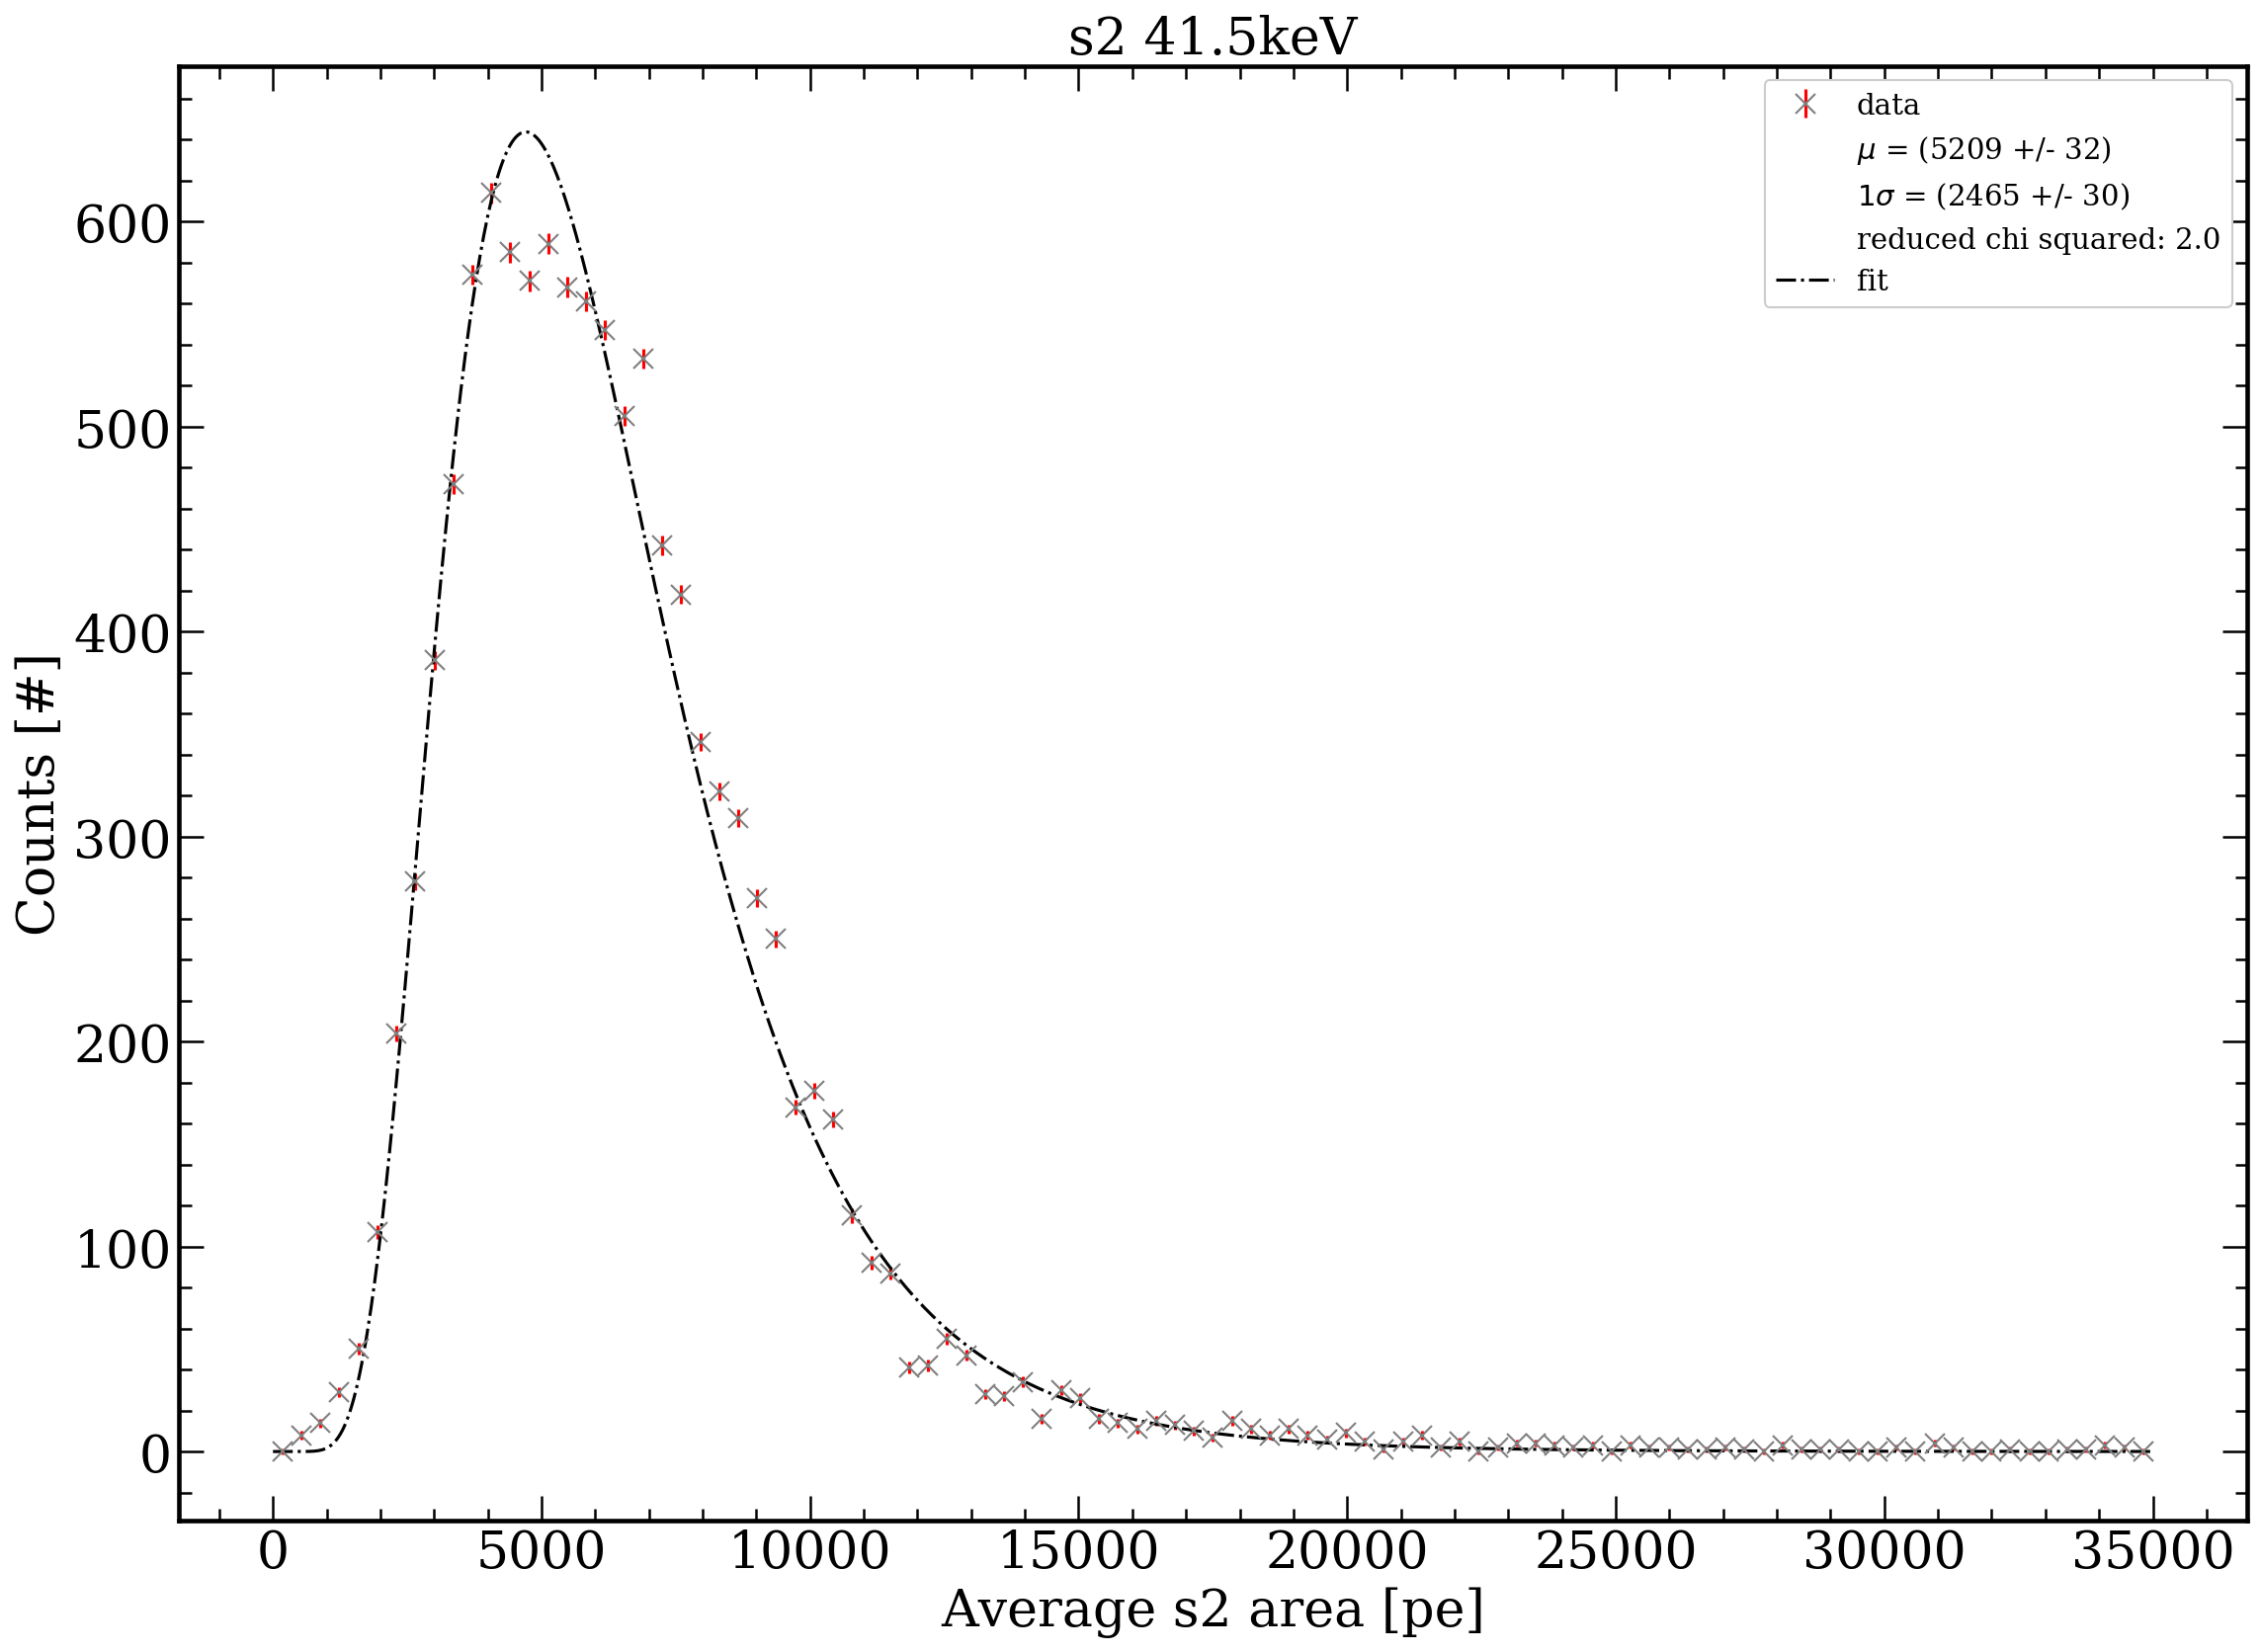

In [25]:
fig, axes = ps.styles()

p0_log = [10,10,10]
p0 = [500,10000,1000]



    
n_s2, binEdges_s2 = np.histogram(cs2, bins=np.linspace(1,35000,100))  #anode at 2500V

poisson_list_s2 = []

for i in n_s2:
    q= fc.poisson_interval(i)[1]
    poisson_list_s2.append(q)


bincenters_s2 = 0.5 * (binEdges_s2[1:] + binEdges_s2[:-1])
x_range_s2 = np.linspace(1,35000,1000)

popt_s2, pcov_s2 = curve_fit(fc.log_gaus, bincenters_s2, n_s2, p0_log,  sigma = poisson_list_s2, absolute_sigma = True, maxfev = 10000)
perr_s2 = np.sqrt(np.diag(pcov_s2))




# expectation_s2 = np.exp(popt_s2[1]-popt_s2[2]**2)
# diff_mu_s2 = expectation_s2
# diff_sigma_s2 = expectation_s2 * 2 * popt_s2[2]
# error_mu_s2 = perr_s2[1]
# error_sigma_s2 = perr_s2[2] 
# error_s2 = np.sqrt(diff_mu_s2**2 * error_mu_s2**2 + diff_sigma_s2**2 * error_sigma_s2**2)






expectation_s2 = np.exp(popt_s2[1]+((popt_s2[2]**2)/2))
diff_mu_s2 = expectation_s2
diff_sigma_s2 = expectation_s2*popt_s2[2]
error_mu_s2 = perr_s2[1]
error_sigma_s2 = perr_s2[2]   
error_s2 = np.sqrt(diff_mu_s2**2 * error_mu_s2**2 + diff_sigma_s2**2 * error_sigma_s2**2)

s2_mu = f"{expectation_s2:.0f}"
s2_error = f"{error_s2:.0f}"




s2_ly = f"{(np.array(expectation_s2)/41.5):.2f}"
s2_ly_error = f"{(np.array(error_s2)/41.5):.2f}"


s2_sigma = np.exp(popt_s2[1]+((popt_s2[2]**2)/2))    * np.sqrt(np.exp(popt_s2[2]**2)-1)
diff_mu_s2 = s2_sigma
diff_sigma_s2 = expectation_s2 * popt_s2[2] * (np.sqrt(np.exp(popt_s2[2]**2)-1)+1/(np.sqrt(np.exp(popt_s2[2]**2)-1))*np.exp(popt_s2[2]**2)) 
s2_sigma_error = np.sqrt(diff_mu_s2**2 *error_mu_s2**2 + diff_sigma_s2**2 * error_sigma_s2**2 )
s2_sigma = "%.0f" % s2_sigma
s2_sigma_error = "%.0f" % s2_sigma_error








xdata_s2=bincenters_s2[1:-1]
ydata_s2=n_s2[1:-1]
chi_squared_s2 =  (np.sum((n_s2 - fc.log_gaus(bincenters_s2, *popt_s2))**2 / np.array(poisson_list_s2)**2))
Reduced_chi_squared_s2 ="%.1f" %( chi_squared_s2 / len(xdata_s2))


axes.errorbar(bincenters_s2, n_s2, yerr=np.sqrt(poisson_list_s2),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red', label='data')

axes.plot(x_range_s2,fc.log_gaus(x_range_s2,*popt_s2), color = 'k', linestyle = '-.', label = 'fit')
#axes.plot([], [], ' ', label="Drift field: 6kV/cm")
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared_s2)
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + s2_sigma + ' +/- '+s2_sigma_error+')')
axes.plot([], [], ' ', label='$\mu$ = ('        + s2_mu + ' +/- '+s2_error+')')
axes.set_title('S2 without correction - Run '+run[2:])

handles,labels = axes.get_legend_handles_labels()
handles = [handles[4],handles[3],handles[2],handles[1],handles[0]]
labels = [labels[4],labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)



axes.set_title('s2 41.5keV')
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s2 area [pe]')
plt.show()


## 3.2 cs2 in keV

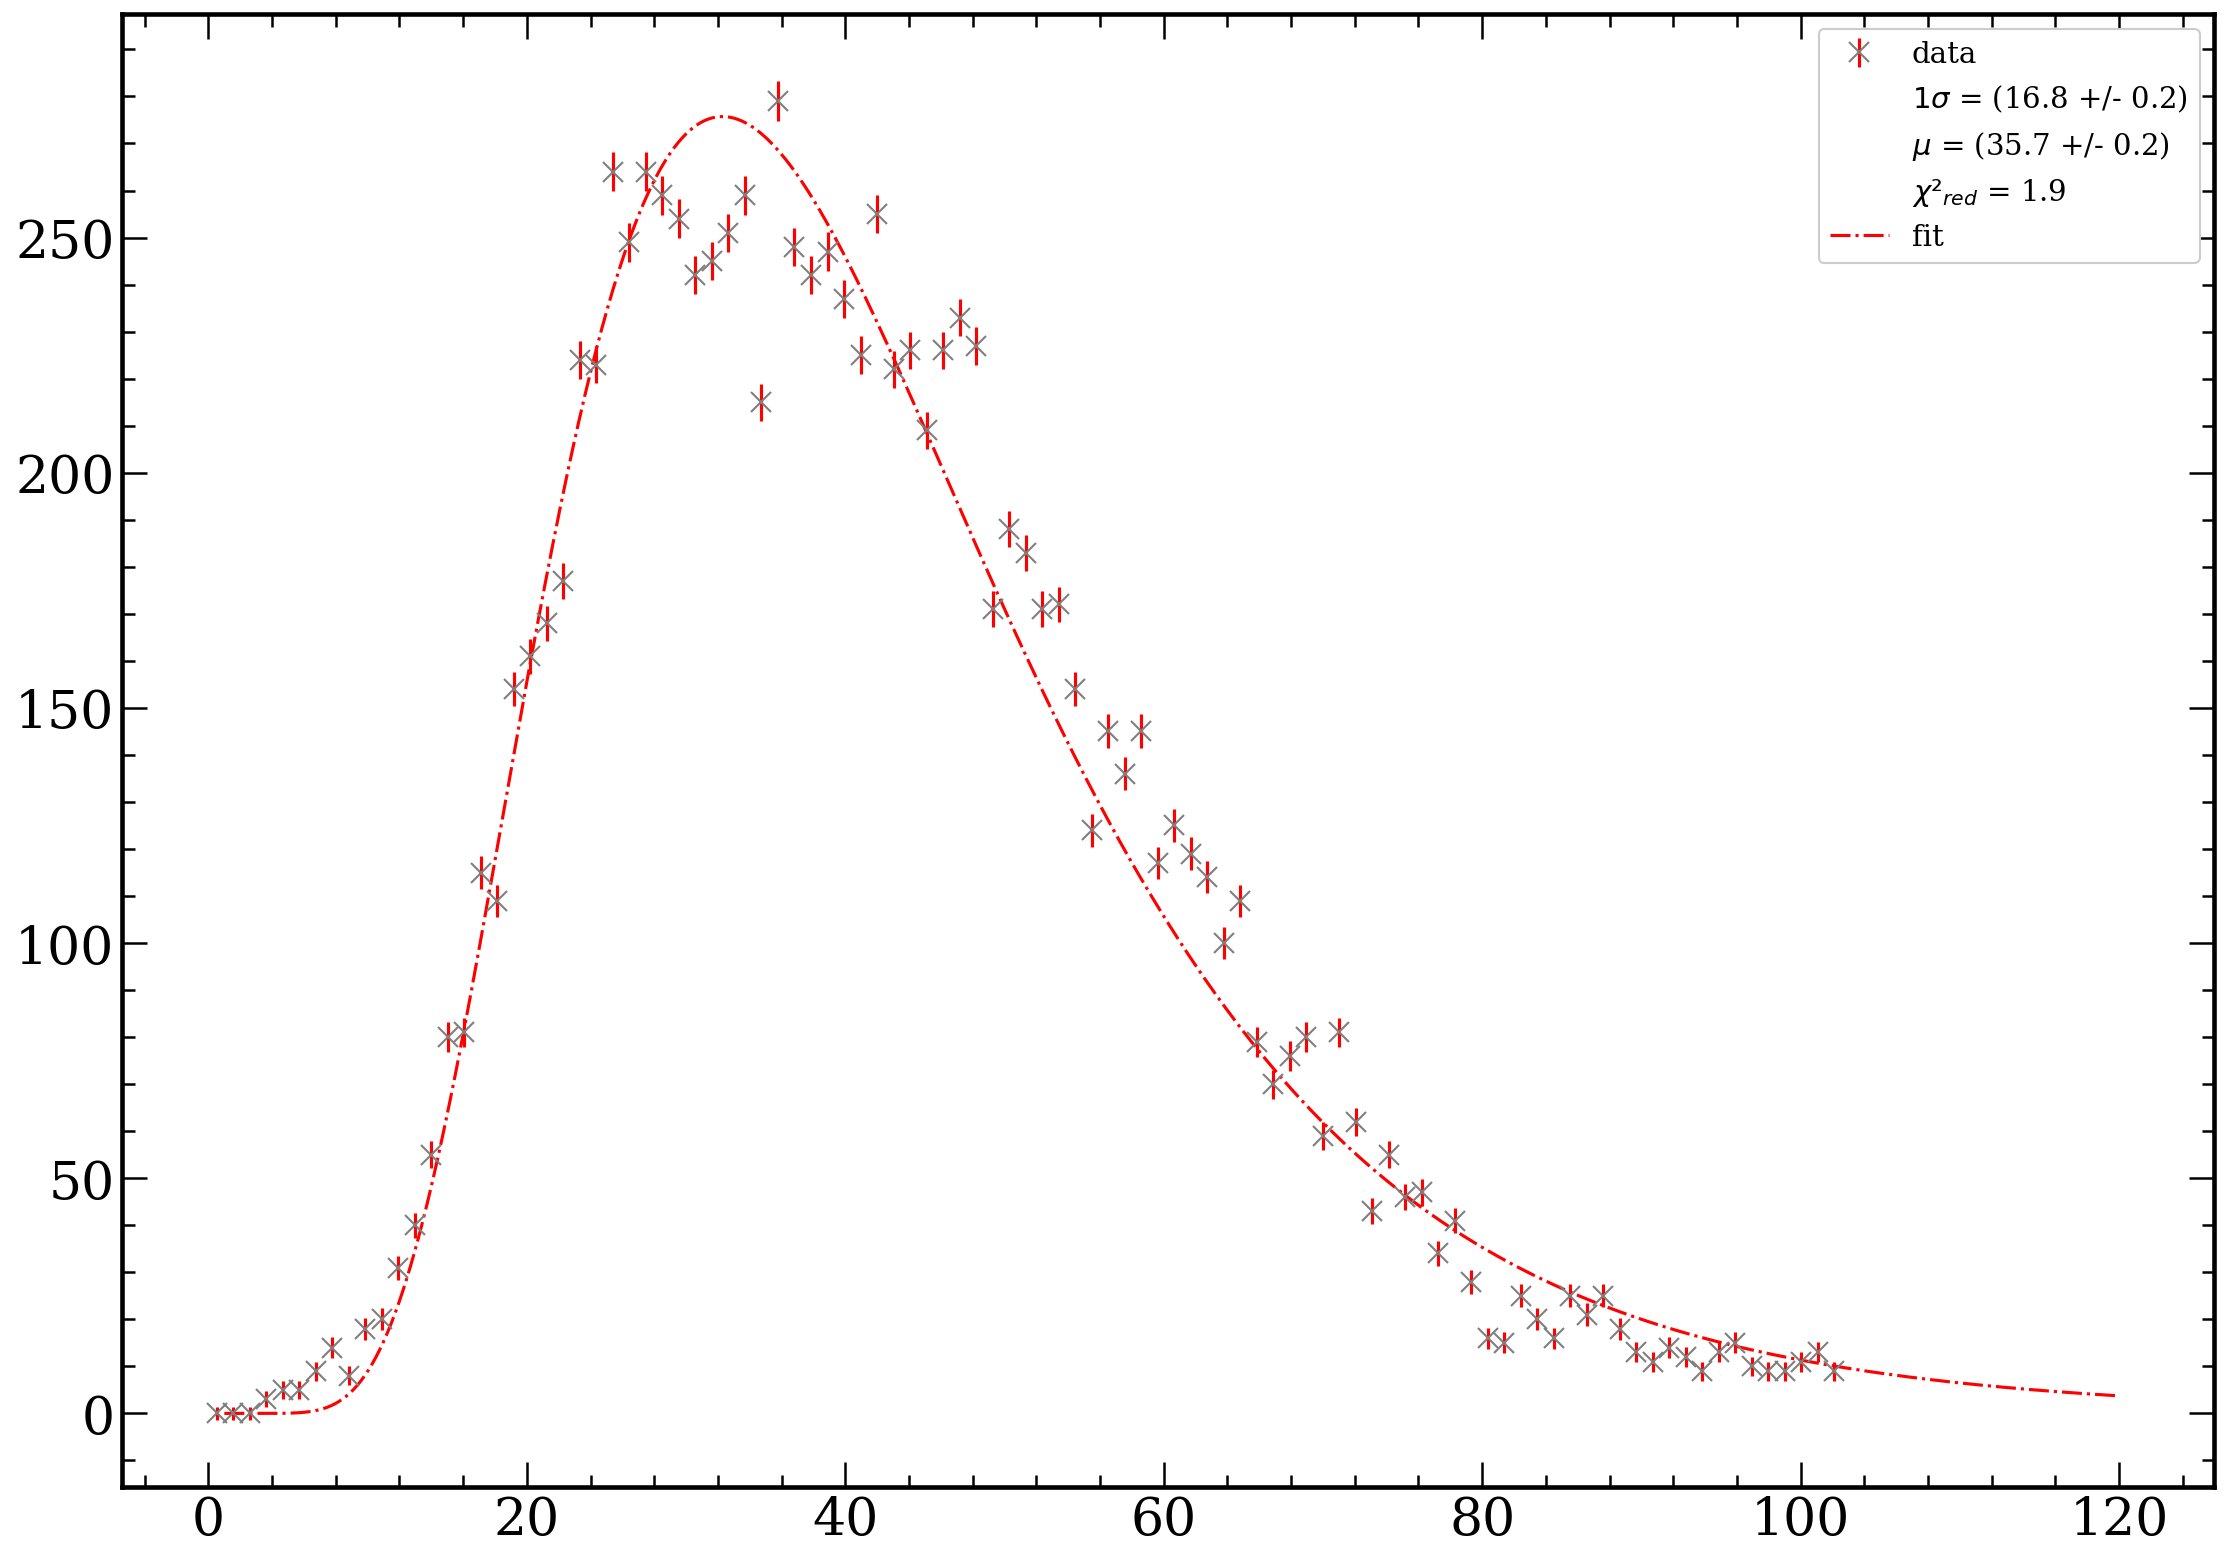

In [24]:
fig, axes = ps.styles()

bincenters_scaled_s2 =np.array(bincenters_s2)/(np.array(expectation_s2)/41.5)
x_range_scaled_s2 = np.linspace(1,120,1000)

poisson_list_scaled_s2 = []

for i in n_s2:
    q= fc.poisson_interval(i)[1]
    poisson_list_scaled_s2.append(q)

popt_scaled_s2, pcov_scaled_s2 = curve_fit(fc.log_gaus, bincenters_scaled_s2, n_s2, p0_log,  sigma = poisson_list_scaled_s2, absolute_sigma = True, maxfev = 10000)
perr_scaled_s2 = np.sqrt(np.diag(pcov_scaled_s2))



# expectation = popt[1]
# error = perr[1]




# expectation_scaled_s2 = np.exp(popt_scaled_s2[1]-popt_scaled_s2[2]**2)
# diff_mu_scaled_s2 = expectation_scaled_s2
# diff_sigma_scaled_s2 = expectation_scaled_s2 * 2 * popt_scaled_s2[2]
# error_mu_scaled_s2 = perr_scaled_s2[1]
# error_sigma_scaled_s2 = perr_scaled_s2[2] 
# error_scaled_s2 = np.sqrt(diff_mu_scaled_s2**2 * error_mu_scaled_s2**2 + diff_sigma_scaled_s2**2 * error_sigma_scaled_s2**2)













expectation_scaled_s2 = np.exp(popt_scaled_s2[1]+((popt_scaled_s2[2]**2)/2))
diff_mu_scaled_s2 = expectation_scaled_s2
diff_sigma_scaled_s2 = expectation_scaled_s2*popt_scaled_s2[2]
error_mu_scaled_s2 = perr_scaled_s2[1]
error_sigma_scaled_s2 = perr_scaled_s2[2]   
error_scaled_s2 = np.sqrt(diff_mu_scaled_s2**2 * error_mu_scaled_s2**2 + diff_sigma_scaled_s2**2 * error_sigma_scaled_s2**2)

s2_scaled_mu = f"{expectation_scaled_s2:.1f}"
s2_scaled_error = f"{error_scaled_s2:.1f}"




xdata_scaled_s2=bincenters_scaled_s2[1:-1]
ydata_scaled_s2=n_s2[1:-1]
chi_squared_scaled_s2 =  (np.sum((n_s2 - fc.log_gaus(bincenters_scaled_s2, *popt_scaled_s2))**2 / np.array(poisson_list_scaled_s2)**2))
Reduced_chi_squared_scaled_s2 ="%.1f" %( chi_squared_scaled_s2 / len(xdata_scaled_s2))


s2_scaled_sigma = np.exp(popt_scaled_s2[1]+((popt_scaled_s2[2]**2)/2))    * np.sqrt(np.exp(popt_scaled_s2[2]**2)-1)
diff_mu_scaled_s2 = s2_scaled_sigma
diff_sigma_scaled_s2 = expectation_scaled_s2 * popt_scaled_s2[2] * (np.sqrt(np.exp(popt_scaled_s2[2]**2)-1)+1/(np.sqrt(np.exp(popt_scaled_s2[2]**2)-1))*np.exp(popt_scaled_s2[2]**2)) 
s2_scaled_sigma_error = np.sqrt(diff_mu_scaled_s2**2 *error_mu_scaled_s2**2 + diff_sigma_scaled_s2**2 * error_sigma_scaled_s2**2 )
s2_scaled_sigma = "%.1f" % s2_scaled_sigma
s2_scaled_sigma_error = "%.1f" % s2_scaled_sigma_error






axes.plot(x_range_scaled_s2,fc.log_gaus(x_range_scaled_s2,*popt_scaled_s2), color = 'red', linestyle = '-.', label = 'fit')
axes.errorbar(bincenters_scaled_s2, n_s2, yerr=np.sqrt(poisson_list_scaled_s2),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red', label = 'data')
axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_scaled_s2)
axes.plot([], [], ' ', label='$\mu$ = ('        + s2_scaled_mu + ' +/- '+s2_scaled_error+')')
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + s2_scaled_sigma + ' +/- '+s2_scaled_sigma_error+')')

handles,labels = axes.get_legend_handles_labels()
handles = [handles[4],handles[3],handles[2],handles[1],handles[0]]
labels = [labels[4],labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)
plt.show()

In [14]:
print(s2_scaled_mu)

41.5


In [15]:
# fig, axes = ps.styles()

# bincenters_scaled_s2 =np.array(bincenters_s2)/(np.array(expectation_s2)/41.5)
# axes.errorbar(bincenters_scaled_s2, n_s2, yerr=np.sqrt(poisson_list_s2),marker = 'o', fmt='.',c = 'C8',markersize='10',ecolor='blue')
# axes.errorbar(bincenters_scaled_s1, n_s1, yerr=np.sqrt(poisson_list_s1),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red')
# plt.show()

# 4. Plots based on combined energy scale

## 4.1 define combined energy scale

In [17]:
E_combined = []

for i in range(len(cs1)):
    E = (     (cs1[i]/g1)     +     (cs2[i]/g2)       )     *     W
    E_combined.append(E)

E_combined = np.array(E_combined)/1000

In [18]:
print(E_combined[:20])
print(sum(np.array(E_combined))/len(E_combined))

[38.04524823 34.88918753 39.68198083 46.25615509 41.00533605 34.45435498
 42.8789113  43.30785114 40.30401471 40.41302405 43.0092376  46.68642595
 45.03518998 47.7325609  41.7180351  53.50495807 37.81855885 42.33782456
 41.10087387 50.83833494]
44.79721584982983


## 4.2 combined in keV

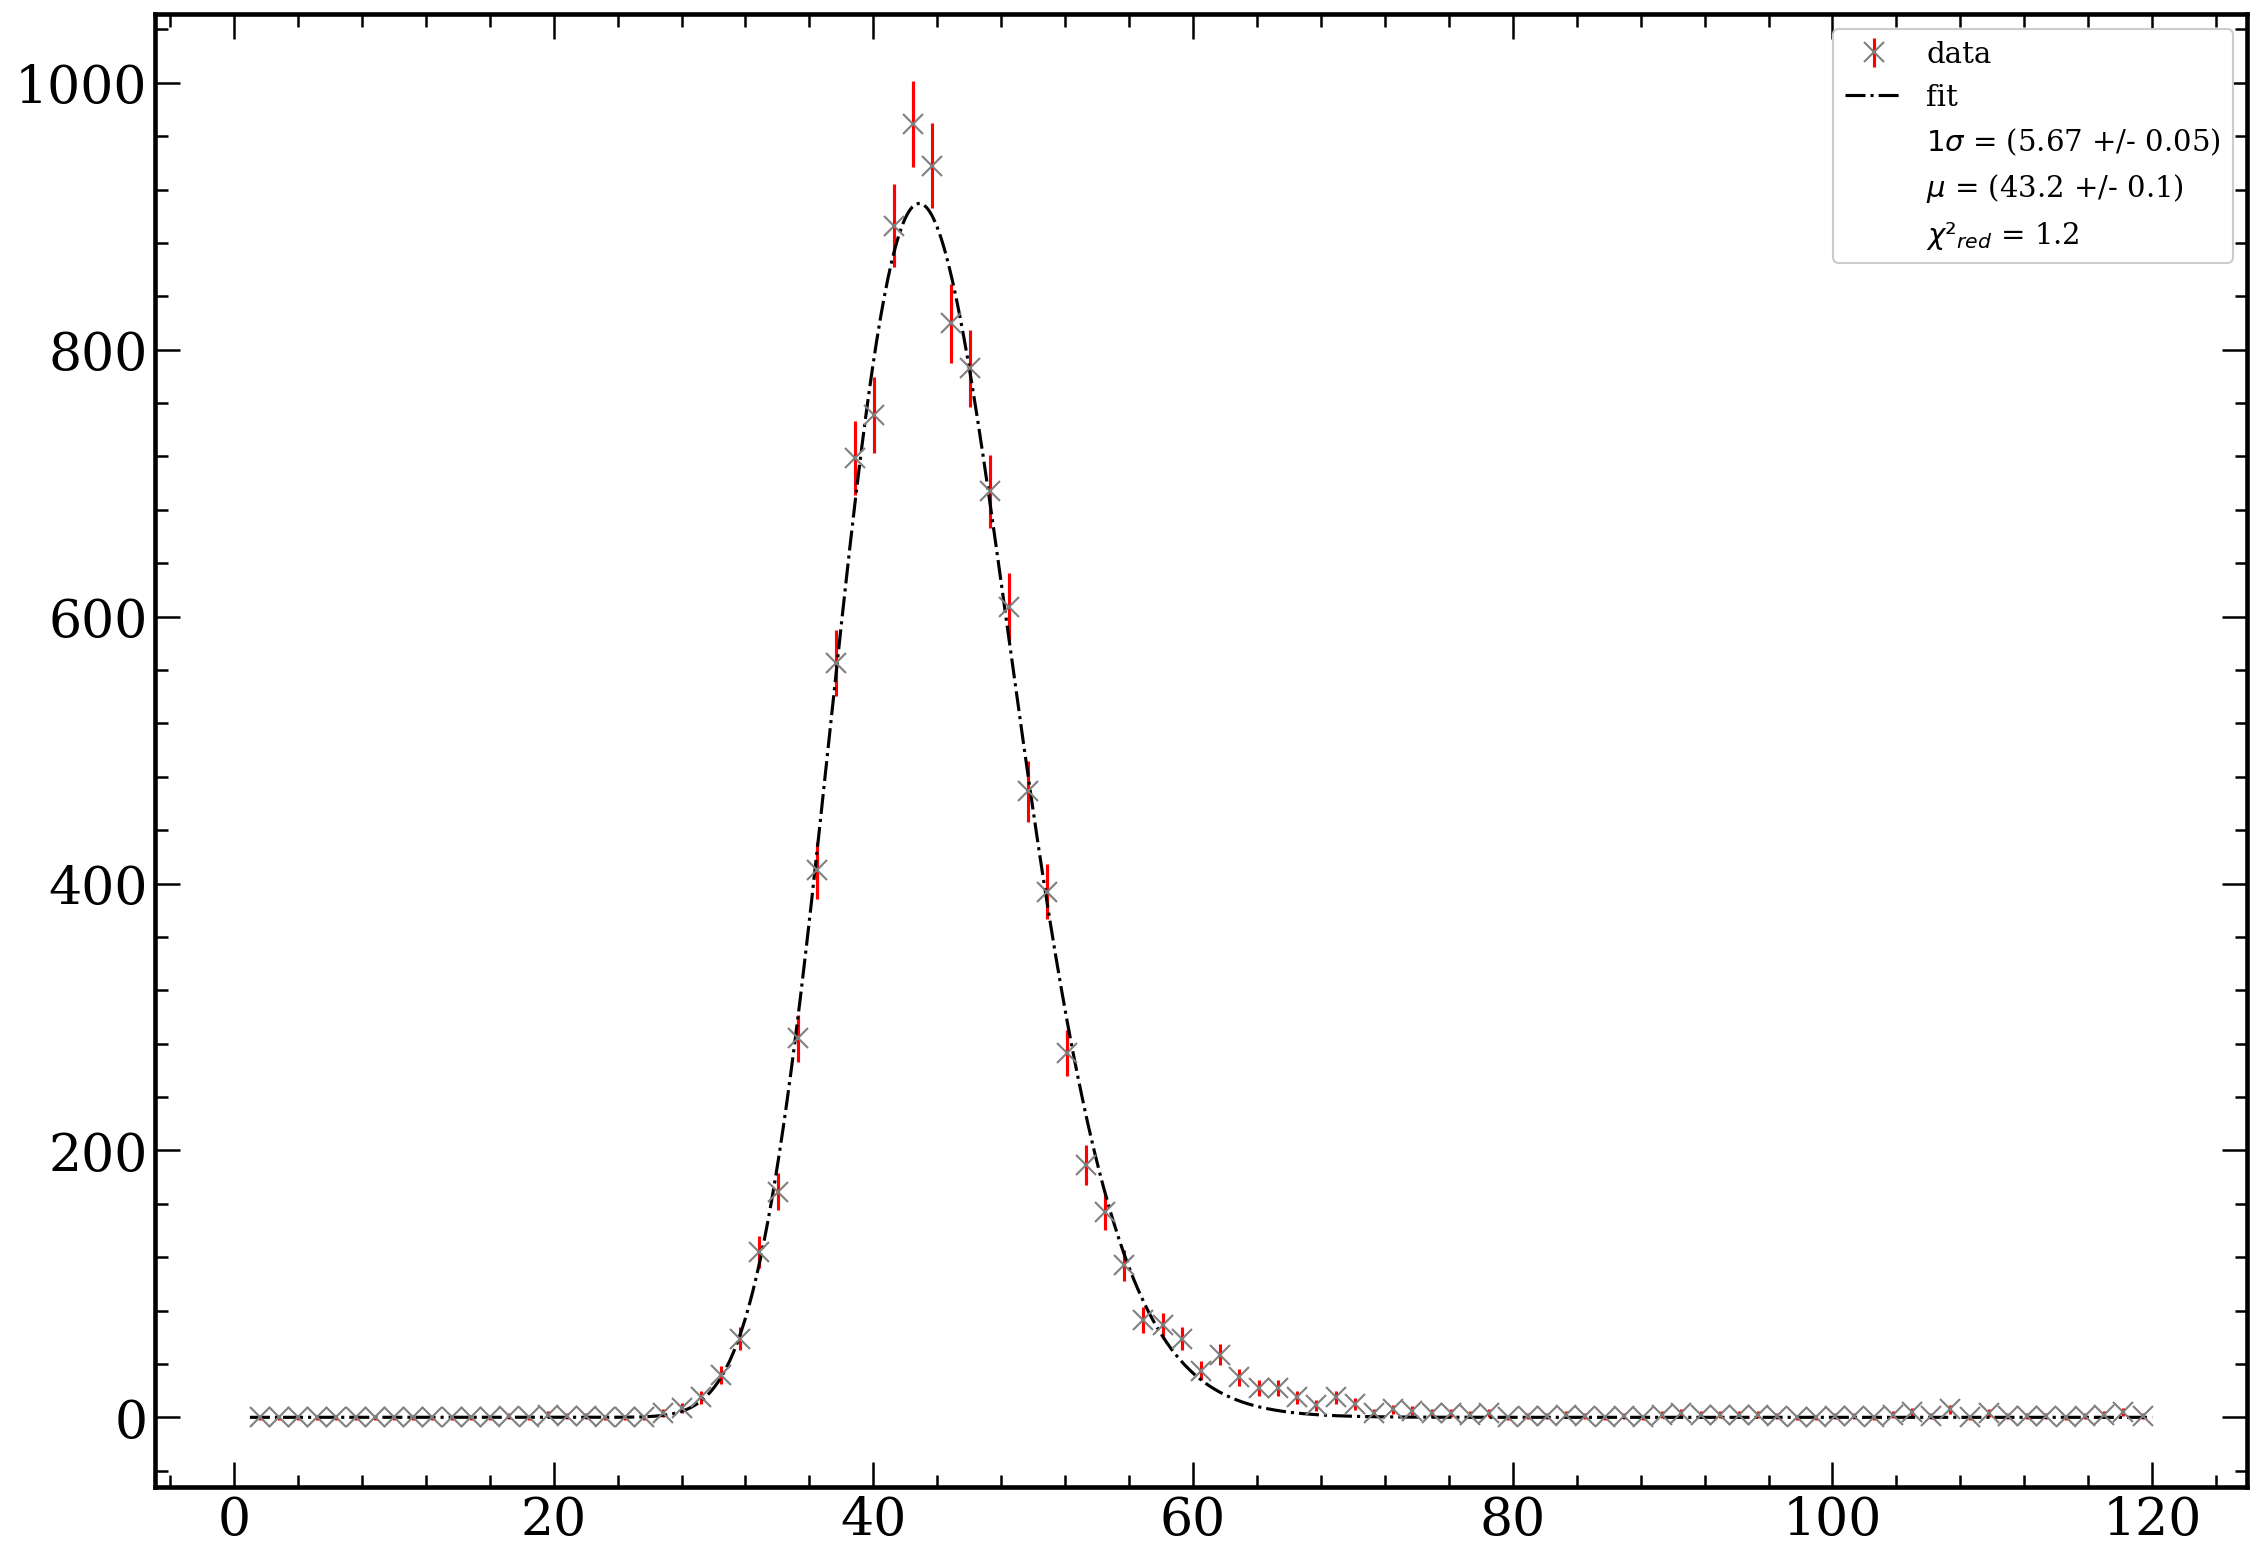

In [23]:
fig, axes = ps.styles()

p0_log = [2,2,2]
p0 = [500,300,60]
x_range_combined = np.linspace(1,120,1000)


    
n_combined, binEdges_combined = np.histogram(E_combined, bins=np.linspace(1,120,100))  #anode at 2500V

poisson_list_combined = []

for i in n_combined:
    q= fc.poisson_interval(i)[1]
    poisson_list_combined.append(q)


bincenters_combined = 0.5 * (binEdges_combined[1:] + binEdges_combined[:-1])



popt_combined, pcov_combined = curve_fit(fc.log_gaus, bincenters_combined, n_combined, p0_log,  sigma = poisson_list_combined, absolute_sigma = True, maxfev = 10000)
perr_combined = np.sqrt(np.diag(pcov_combined))



expectation_combined = np.exp(popt_combined[1]+((popt_combined[2]**2)/2))
diff_mu_combined = expectation_combined
diff_sigma_combined = expectation_combined*popt_combined[2]
error_mu_combined = perr_combined[1]
error_sigma_combined = perr_combined[2]   
error_combined = np.sqrt(diff_mu_combined**2 * error_mu_combined**2 + diff_sigma_combined**2 * error_sigma_combined**2)








# expectation_combined = np.exp(popt_combined[1]-popt_combined[2]**2)
# diff_mu_combined = expectation_combined
# diff_sigma_combined = expectation_combined*2*popt_combined[2]
# error_mu_combined = perr_combined[1]
# error_sigma_combined = perr_combined[2]   
# error_combined = np.sqrt(diff_mu_combined**2 * error_mu_combined**2 + diff_sigma_combined**2 * error_sigma_combined**2)

combined_mu = f"{expectation_combined:.1f}"
combined_error = f"{error_combined:.1f}"



combined_sigma = np.exp(popt_combined[1]+((popt_combined[2]**2)/2))    * np.sqrt(np.exp(popt_combined[2]**2)-1)
diff_mu_combined = combined_sigma
diff_sigma_combined = expectation_combined * popt_combined[2] * (np.sqrt(np.exp(popt_combined[2]**2)-1)+1/(np.sqrt(np.exp(popt_combined[2]**2)-1))*np.exp(popt_combined[2]**2)) 
combined_sigma_error = np.sqrt(diff_mu_combined**2 *error_mu_combined**2 + diff_sigma_combined**2 * error_sigma_combined**2 )
combined_sigma =  "%.2f" % combined_sigma
combined_sigma_error =  "%.2f" % combined_sigma_error



# s2_scaled_sigma = np.exp(popt_scaled_s2[1]+((popt_scaled_s2[2]**2)/2))    * np.sqrt(np.exp(popt_scaled_s2[2]**2)-1)
# diff_mu_scaled_s2 = s2_scaled_sigma
# diff_sigma_scaled_s2 = expectation_scaled_s2 * popt_scaled_s2[2] * (np.sqrt(np.exp(popt_scaled_s2[2]**2)-1)+1/(np.sqrt(np.exp(popt_scaled_s2[2]**2)-1))*np.exp(popt_scaled_s2[2]**2)) 
# s2_scaled_sigma_error = np.sqrt(diff_mu_scaled_s2**2 *error_mu_scaled_s2**2 + diff_sigma_scaled_s2**2 * error_sigma_scaled_s2**2 )
# s2_scaled_sigma = "%.2f" % s2_scaled_sigma
# s2_scaled_sigma_error = "%.2f" % s2_scaled_sigma_error



xdata_combined=bincenters_combined[1:-1]
ydata_combined=n_combined[1:-1]
chi_squared_combined =  (np.sum((n_combined - fc.log_gaus(bincenters_combined, *popt_combined))**2 / np.array(poisson_list_combined)**2))
Reduced_chi_squared_combined ="%.1f" %( chi_squared_combined / len(xdata_combined))

axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_combined)
axes.plot([], [], ' ', label='$\mu$ = ('        + combined_mu + ' +/- '+combined_error+')')
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + combined_sigma + ' +/- '+combined_sigma_error+')')
axes.plot(x_range_combined,fc.log_gaus(x_range_combined,*popt_combined), color = 'k', linestyle = '-.', label = 'fit')
axes.errorbar(bincenters_combined, n_combined, yerr=poisson_list_combined,marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red', label='data')



handles,labels = axes.get_legend_handles_labels()
handles = [handles[4],handles[3],handles[2],handles[1],handles[0]]
labels = [labels[4],labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)
plt.show()


# 5. Compare energy resolution

In [19]:
# fig, axes = ps.styles()

# bincenters_scaled_s2 =np.array(bincenters_s2)/(np.array(expectation_s2)/41.5)
# axes.errorbar(bincenters_scaled_s2, n_s2, yerr=np.sqrt(poisson_list_s2),marker = 'o', fmt='.',c = 'C8',markersize='10',ecolor='blue')
# axes.errorbar(bincenters_scaled_s1, n_s1, yerr=np.sqrt(poisson_list_s1),marker = 'x', fmt='.',c = 'C7',markersize='10',ecolor='red')
# axes.errorbar(bincenters, n, yerr=np.sqrt(poisson_list),marker = '^', fmt='.',c = 'C6',markersize='10',ecolor='green')
# plt.show()

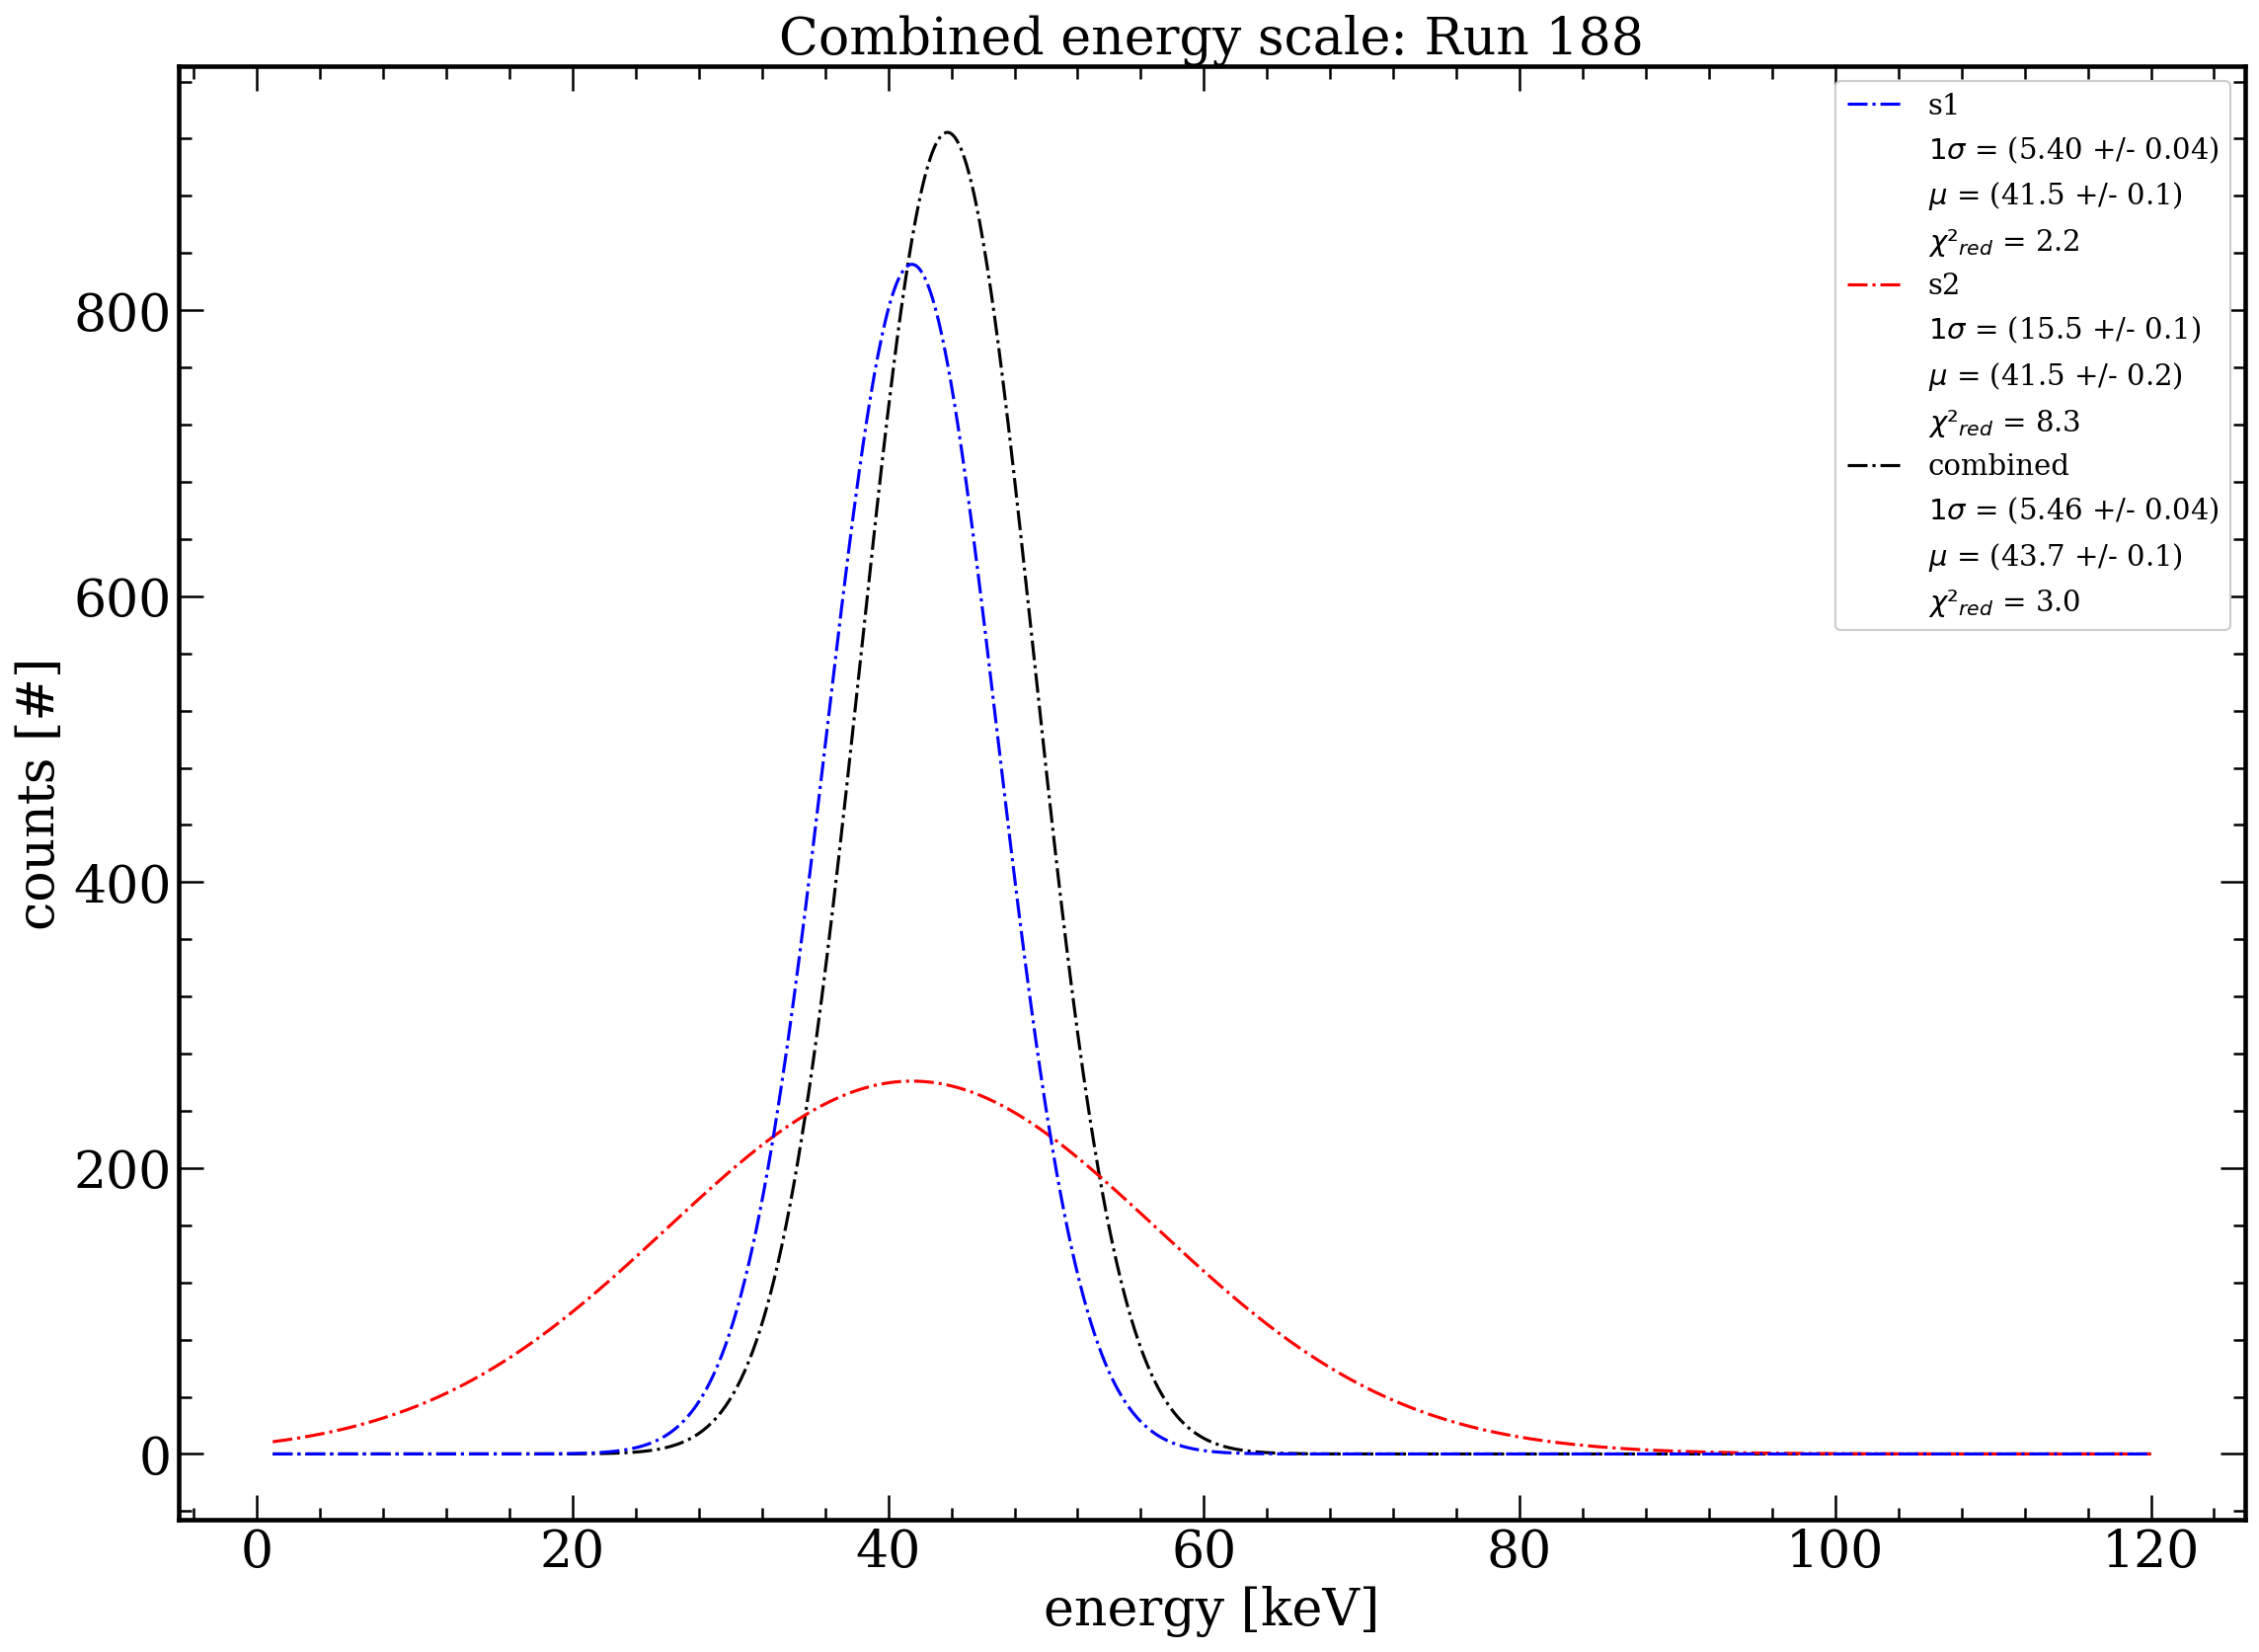

In [22]:
fig, axes = ps.styles()

axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_combined)
axes.plot([], [], ' ', label='$\mu$ = ('        + combined_mu + ' +/- '+combined_error+')')
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + combined_sigma + ' +/- '+combined_sigma_error+')')
axes.plot(x_range_combined,fc.log_gaus(x_range_combined,*popt_combined), color = 'k', linestyle = '-.', label = 'combined')



axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_scaled_s2)
axes.plot([], [], ' ', label='$\mu$ = ('        + s2_scaled_mu + ' +/- '+s2_scaled_error+')')
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + s2_scaled_sigma + ' +/- '+s2_scaled_sigma_error+')')
axes.plot(x_range_scaled_s2,fc.log_gaus(x_range_scaled_s2,*popt_scaled_s2), color = 'red', linestyle = '-.', label = 's2')


axes.plot([], [], ' ', label='$\chi²_{red}$ = '        +Reduced_chi_squared_scaled_s1)
axes.plot([], [], ' ', label='$\mu$ = ('        + s1_scaled_mu + ' +/- '+s1_scaled_error+')')
axes.plot([], [], ' ', label='$1 \sigma$ = ('        + s1_scaled_sigma + ' +/- '+s1_scaled_sigma_error+')')
axes.plot(x_range_scaled_s1,fc.log_gaus(x_range_scaled_s1,*popt_scaled_s1), color = 'blue', linestyle = '-.', label = 's1')



handles,labels = axes.get_legend_handles_labels()
handles = [handles[11],handles[10],handles[9],handles[8],handles[7],handles[6],handles[5],handles[4],handles[3],handles[2],handles[1],handles[0]]
labels = [labels[11],labels[10],labels[9],labels[8],labels[7],labels[6],labels[5],labels[4],labels[3],labels[2],labels[1],labels[0]]
axes.legend(handles,labels, loc = 1,prop={'size': 14}, fancybox=True, framealpha=1)
axes.set_title('Combined energy scale: Run '+run[2:])
axes.set_xlabel('energy [keV]')
axes.set_ylabel('counts [#]')
plt.show()


In [21]:
print('combined: ',float(combined_sigma)/float(combined_mu))
print('s1: ',float(s1_scaled_sigma)/float(s1_scaled_mu))

combined:  0.1293859649122807
s1:  0.13349397590361445
